# ECG Noise Quantification Demo
This notebook demonstrates the use of the ecg_noise_quantification function for computing global and local PSNR (Peak Signal-to-Noise Ratio) on single-lead and multi-lead ECG signals. It includes visualization of raw ECG signals, input/output scalograms, and PSNR values/MSE maps.

### Setup
Load required libraries and pretrained model checkpoint.

#### 🔗 Pretrained Model
You can download the pretrained latent diffusion model from 🤗 Hugging Face:

👉 [Download pretrained model](https://huggingface.co/Taeseong-Han/ECGNoiseQuantification/blob/main/pretrained_ldm.pth)

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from utils.inference import ecg_noise_quantification

checkpoint_path = "./output/pretrained_ldm.pth"  # Update with the correct path to the pretrained model

### Example1 - Single-lead, Gloabal PSNR
Compute and visualize global PSNR for a single-lead ECG signal.

In [58]:
# Load single-lead ECG data
ecg = np.load("./data/database/ecg_example.npz")['signal']

# Compute global PSNR (n_partitions=1)
output = ecg_noise_quantification(
    ecg=ecg,
    sampling_freq=500,
    checkpoint_path=checkpoint_path,
    n_partitions=1,
)

print(f"ECG shape: {ecg.shape}")
print(f"Input sclaogram shape: {output.cleaned_image.shape}")  # (leads, segments, H, W)
print(f"Output sclaogram shape: {output.original_image.shape}")  # (leads, segments, H, W)
print(f"PSNR shape: {output.psnr.shape}")  # (leads, segments)

ECG shape: (5000,)
Input sclaogram shape: (1, 1, 32, 256)
Output sclaogram shape: (1, 1, 32, 256)
PSNR shape: (1, 1)


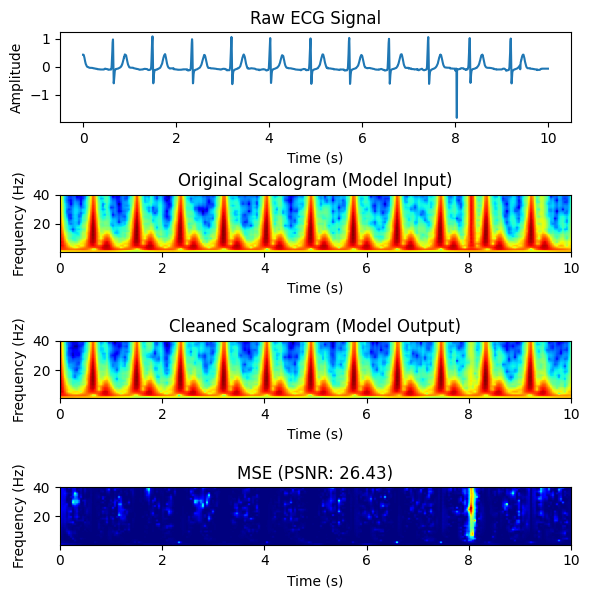

In [59]:
# Visualize results

# Global PSNR: Single column plot
fig, axes = plt.subplots(4, 1, figsize=(6, 6))

# Raw ECG signal
t_signal = np.linspace(0, 10, len(ecg))
axes[0].plot(t_signal, ecg)
axes[0].set_title("Raw ECG Signal")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Amplitude")

# Original scalogram
original_image = np.squeeze(output.original_image)
axes[1].imshow(original_image, cmap='jet', extent=[0, 10, 0.5, 40], aspect=1 / 35)
axes[1].set_title("Original Scalogram (Model Input)")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Frequency (Hz)")

# Cleaned scalogram
cleaned_image = np.squeeze(output.cleaned_image)
axes[2].imshow(cleaned_image, cmap='jet', extent=[0, 10, 0.5, 40], aspect=1 / 35)
axes[2].set_title("Cleaned Scalogram (Model Output)")
axes[2].set_xlabel("Time (s)")
axes[2].set_ylabel("Frequency (Hz)")

# MSE with PSNR annotation
mse = (original_image - cleaned_image) ** 2
axes[3].imshow(mse, cmap='jet', extent=[0, 10, 0.5, 40], aspect=1 / 35)
axes[3].set_title(f"MSE (PSNR: {output.psnr[0, 0]:.2f})")
axes[3].set_xlabel("Time (s)")
axes[3].set_ylabel("Frequency (Hz)")

plt.tight_layout()
plt.show()

### Example2 - Single-Lead, Local PSNR
Compute and visualize local PSNR for a single-lead ECG signal with 8 partitions.

In [55]:
# Compute local PSNR (n_partitions=8)
output = ecg_noise_quantification(
    ecg=ecg,
    sampling_freq=500,
    checkpoint_path=checkpoint_path,
    n_partitions=8,  # Local PSNR parameter
)

print(f"ECG shape: {ecg.shape}")
print(f"Input sclaogram shape: {output.cleaned_image.shape}")  # (leads, segments, H, W)
print(f"Output sclaogram shape: {output.original_image.shape}")  # (leads, segments, H, W)
print(f"PSNR shape: {output.psnr.shape}")  # (leads, segments)

ECG shape: (5000,)
Input sclaogram shape: (1, 1, 32, 256)
Output sclaogram shape: (1, 1, 32, 256)
PSNR shape: (1, 8)


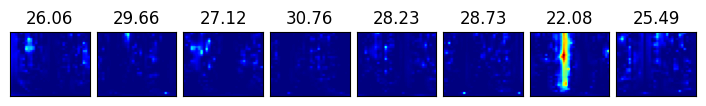

In [56]:
# Local PSNR: Multi-column plot for partitions
vmin, vmax = mse.min(), mse.max()
plt.figure(figsize=(7, 1))

for i in range(8):
    ax = plt.subplot(1, 8, i + 1)
    plt.title(f"{output.psnr[0, i]:.2f}")
    ax.imshow(mse[:, i * 32:(i + 1) * 32], cmap='jet', extent=[0, 10, 0.5, 40], vmin=vmin, vmax=vmax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_aspect('auto')

plt.subplots_adjust(wspace=0.05, hspace=0)
plt.tight_layout(pad=0.5)
plt.show()

### Example 3: Multi-Lead, Global and Local PSNR
Compute and global and local PSNR for a synthetic multi-lead ECG signal.

In [57]:
# Generate synthetic multi-lead ECG data
ecg = np.random.randn(12, 12000)

# Global PSNR (n_partitions=1)
output = ecg_noise_quantification(
    ecg=ecg,
    sampling_freq=500,
    checkpoint_path=checkpoint_path,
    n_partitions=1,
)

print("Multi-lead, Global PSNR")
print(ecg.shape)
print(output.cleaned_image.shape)  # (leads, segments, H, W)
print(output.original_image.shape)  # (leads, segments, H, W)
print(output.psnr.shape)  # (leads, segments)

# Local PSNR (n_partitions=8)
output = ecg_noise_quantification(
    ecg=ecg,
    sampling_freq=500,
    checkpoint_path=checkpoint_path,
    n_partitions=8,
)

print("Multi-lead, Local PSNR")
print(ecg.shape)
print(output.cleaned_image.shape)  # (leads, segments, H, W)
print(output.original_image.shape)  # (leads, segments, H, W)
print(output.psnr.shape)  # (leads, segments)

Multi-lead, Global PSNR
(12, 12000)
(12, 3, 32, 256)
(12, 3, 32, 256)
(12, 3)
Multi-lead, Local PSNR
(12, 12000)
(12, 3, 32, 256)
(12, 3, 32, 256)
(12, 20)


### 📌 Explanation of Output Shapes

#### 🧩 Number of Segments
The input ECG is automatically divided into 10-second segments based on the sampling frequency (500 Hz). For example, an ECG with shape `(12, 12000)` at 500 Hz corresponds to 24 seconds of data, resulting in:

- **2 full segments** (each 10 sec × 500 Hz = 5000 samples)
- **1 partial segment** with only 2000 samples remaining

To maintain uniform segment length, the final 10-second segment is constructed by padding the remaining 2000 samples with 3000 samples from earlier in the signal, i.e., using samples `[7000:12000]`.

However, when computing the PSNR for this last segment, only the valid portion (2000 samples) is considered. This ensures the quality metric accurately reflects the actual content, avoiding bias from reused data.

#### 📐 Number of Partitions (`n_partitions`)
Each 10-second segment can be subdivided into smaller partitions for detailed analysis:

- **Global PSNR (`n_partitions=1`)**:
  Computes a single PSNR value per segment, resulting in a PSNR shape of `(leads, segments)` (e.g., `(12, 3)`).

- **Local PSNR (`n_partitions=8`)**:
  Each segment is further divided into 8 smaller partitions, producing finer-grained PSNR measurements. Due to partially filled partitions (particularly in the last segment), the total number of PSNR values might differ slightly from a simple multiplication. Thus, the resulting PSNR shape is `(leads, total_valid_partitions)` (e.g., `(12, 20)`), excluding partitions without sufficient valid data.

This flexibility allows users to analyze ECG quality at different granularities, from coarse (global) to fine-grained (local) levels.